In [44]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") #

## Load Data

In [36]:
%pip install prophet

In [45]:
#@title Load your dataset
!wget -q --show-progress "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20%2B%20X/Group/Environment/Pollution/pollution_2000_2021.csv"
pollution_data = pd.read_csv('pollution_2000_2021.csv')

'wget' is not recognized as an internal or external command,
operable program or batch file.


## Filter Data

In [46]:
# filter to New York
pollution_data_ny = pollution_data[pollution_data['City'] == 'New York']

# filter to Date
pollution_data_ny= pollution_data_ny[pollution_data_ny['Date'] >= '2013-01-01']
pollution_data_ny['Date']= pd.to_datetime(pollution_data_ny['Date'])

pollution_data_ny.head()

,Date,Year,Month,Day,Address,State,County,City,O3 Mean,O3 1st Max Value,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
357115,2013-01-01,2013,1,1,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.023824,0.026,...,5,7.0,5.408333,9.2,6,13.0,16.470833,22.2,6,21
357116,2013-01-02,2013,1,2,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.020471,0.023,...,7,6.0,6.045455,9.0,20,13.0,18.650000,27.8,8,25
357117,2013-01-03,2013,1,3,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.013059,0.021,...,9,7.0,6.687500,11.5,21,16.0,24.033333,36.0,19,34
357118,2013-01-04,2013,1,4,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.016588,0.021,...,6,7.0,7.762500,12.2,4,17.0,28.195833,39.3,7,37
357119,2013-01-05,2013,1,5,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.014647,0.027,...,21,9.0,7.004167,10.5,21,14.0,24.966667,44.1,20,42


In [4]:
pollution_data

,Date,Year,Month,Day,Address,State,County,City,O3 Mean,O3 1st Max Value,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000-01-01,2000,1,1,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000-01-02,2000,1,2,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000-01-03,2000,1,3,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000-01-04,2000,1,4,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000-01-05,2000,1,5,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608694,2021-06-26,2021,6,26,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.040588,0.049,...,0,1.0,0.409091,0.7,2,0.0,1.281818,2.1,0,2
608695,2021-06-27,2021,6,27,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.037882,0.042,...,0,1.0,0.325000,0.4,4,0.0,1.104167,2.3,20,2
608696,2021-06-28,2021,6,28,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.039765,0.050,...,0,1.0,0.326087,0.5,2,0.0,1.678261,5.8,23,5
608697,2021-06-29,2021,6,29,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.049176,0.058,...,0,1.0,0.317391,0.5,20,0.0,2.934783,7.4,0,7


In [47]:
df = pollution_data_ny[['O3 Mean', 'Date']]

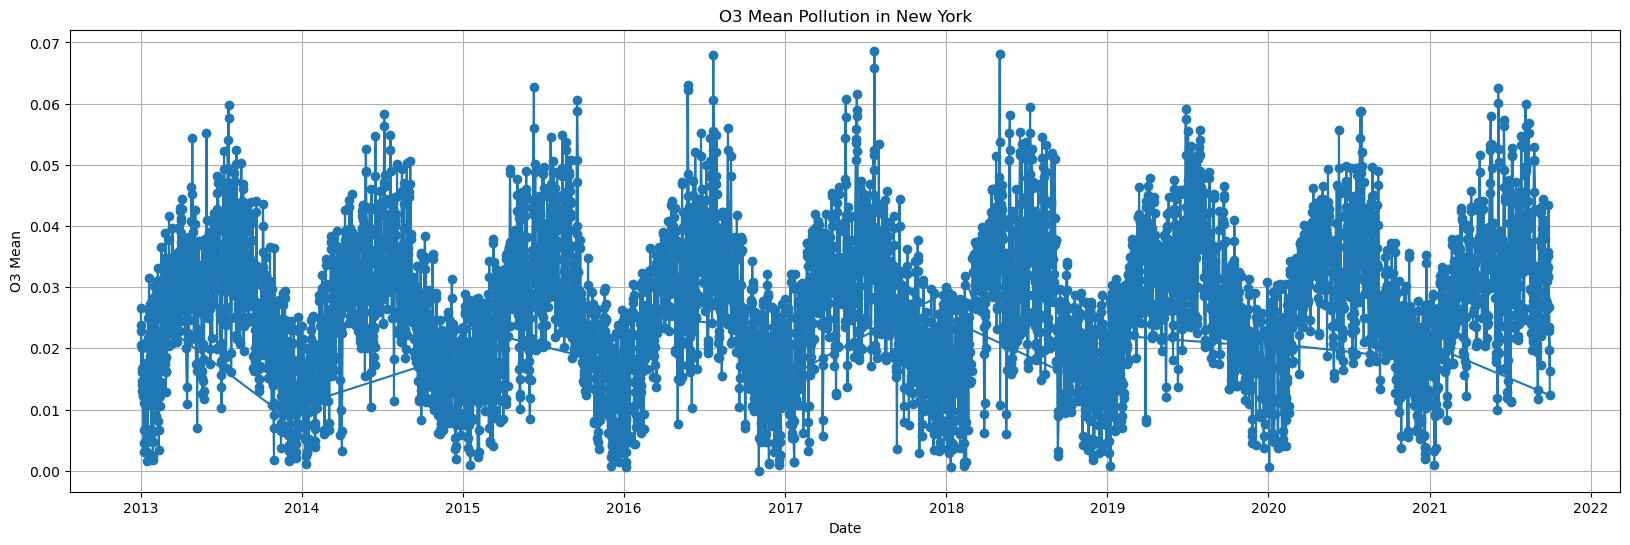

In [37]:
df['Date'] = pd.to_datetime(df['Date'])

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(df['Date'], df['O3 Mean'], marker='o', linestyle='-')
plt.title('O3 Mean Pollution in New York')
plt.xlabel('Date')
plt.ylabel('O3 Mean')
plt.grid(True)
plt.show()

## O3_Mean Dataframe

#### O3_Mean Original Time-Series and Decomposition

In [30]:
df_O3 = pollution_data_ny[['Date','O3 Mean']].groupby(['Date']).agg({'O3 Mean': 'mean'})
df_O3.set_index('Date',inplace=True)

plt.figure(figsize=(20,5));
plt.plot(df_O3)

KeyError: "None of ['Date'] are in the columns"

Text(0.5, 0.98, 'Decomposition of multiplicative time series')

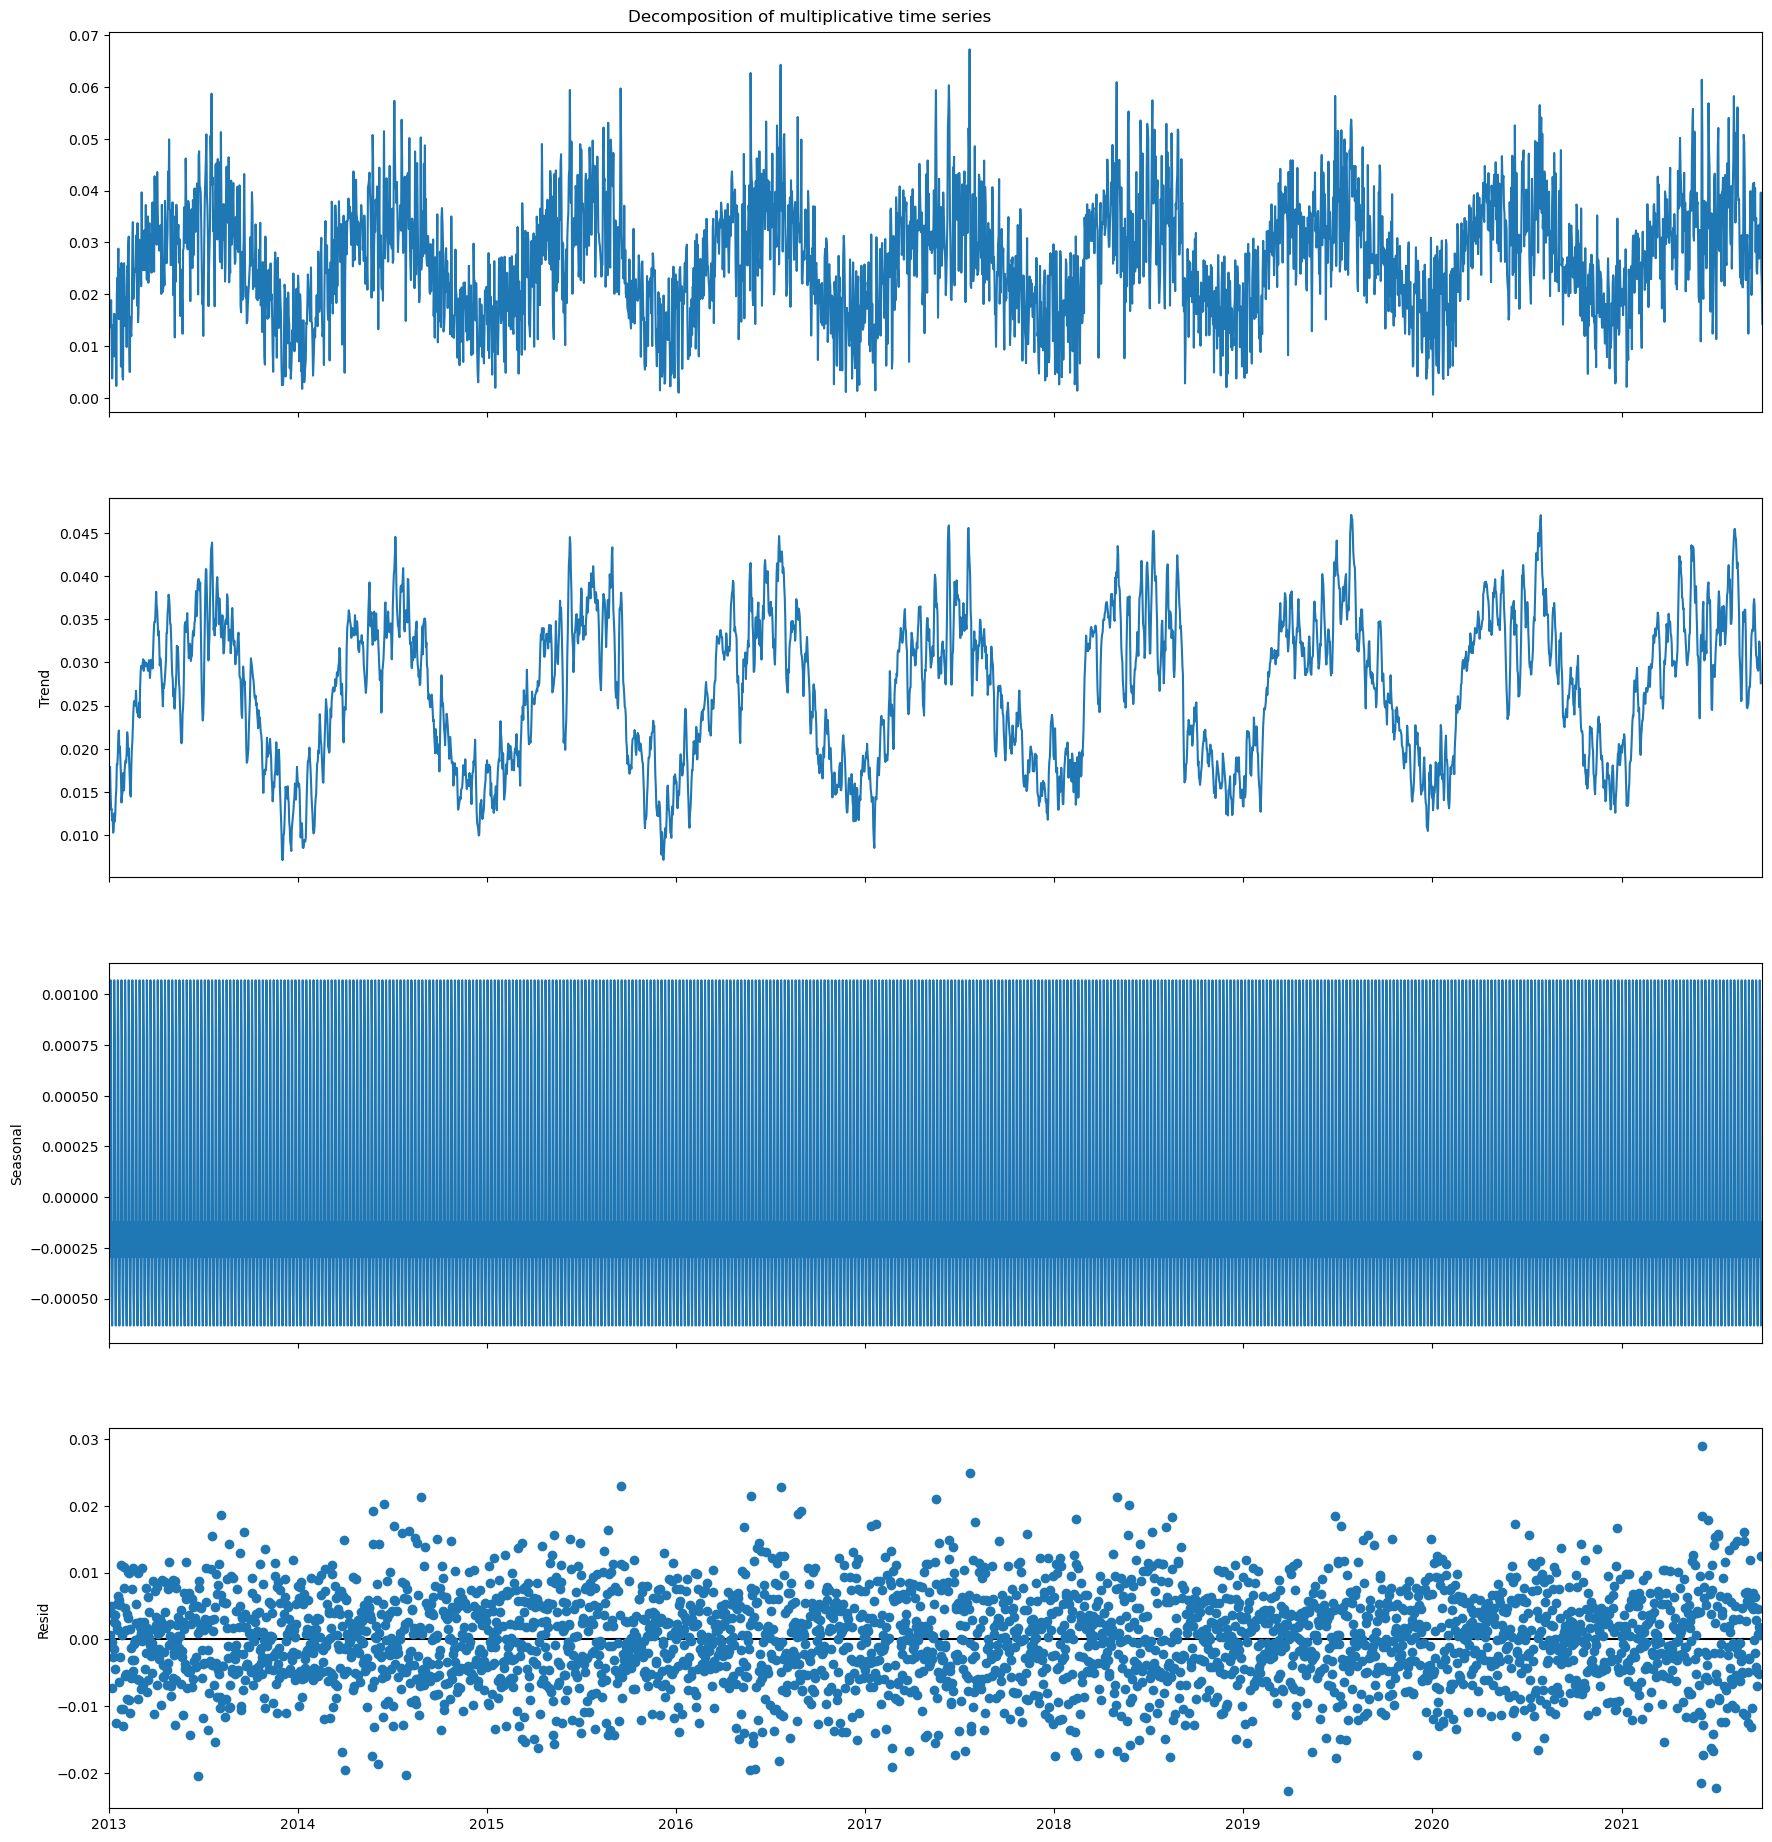

In [6]:
# fill-in missing dates
df_O3_filled = df_O3.asfreq('D')
df_O3_filled = df_O3_filled.ffill()

# decompose time-series
decomposition = seasonal_decompose(df_O3_filled, model='additive')

# plot decomposed time-series data
fig = decomposition.plot()
fig.set_figwidth(20)
fig.set_figheight(20)
plt.suptitle('Decomposition of multiplicative time series')

#### O3_Mean Resampled Time-Series and Decomposition

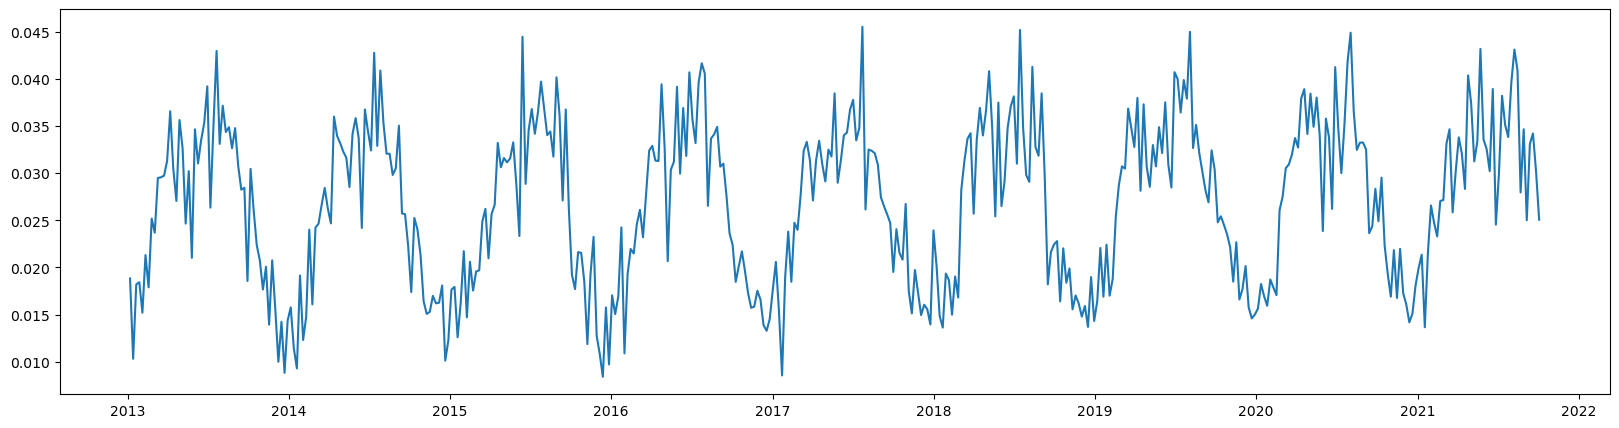

In [8]:
W = df_O3.resample('W').mean() #df_O3.rolling(window=30).mean().dropna()
plt.figure(figsize=(20,5));
plt.plot(W)

Text(0.5, 0.98, 'Decomposition of multiplicative time series')

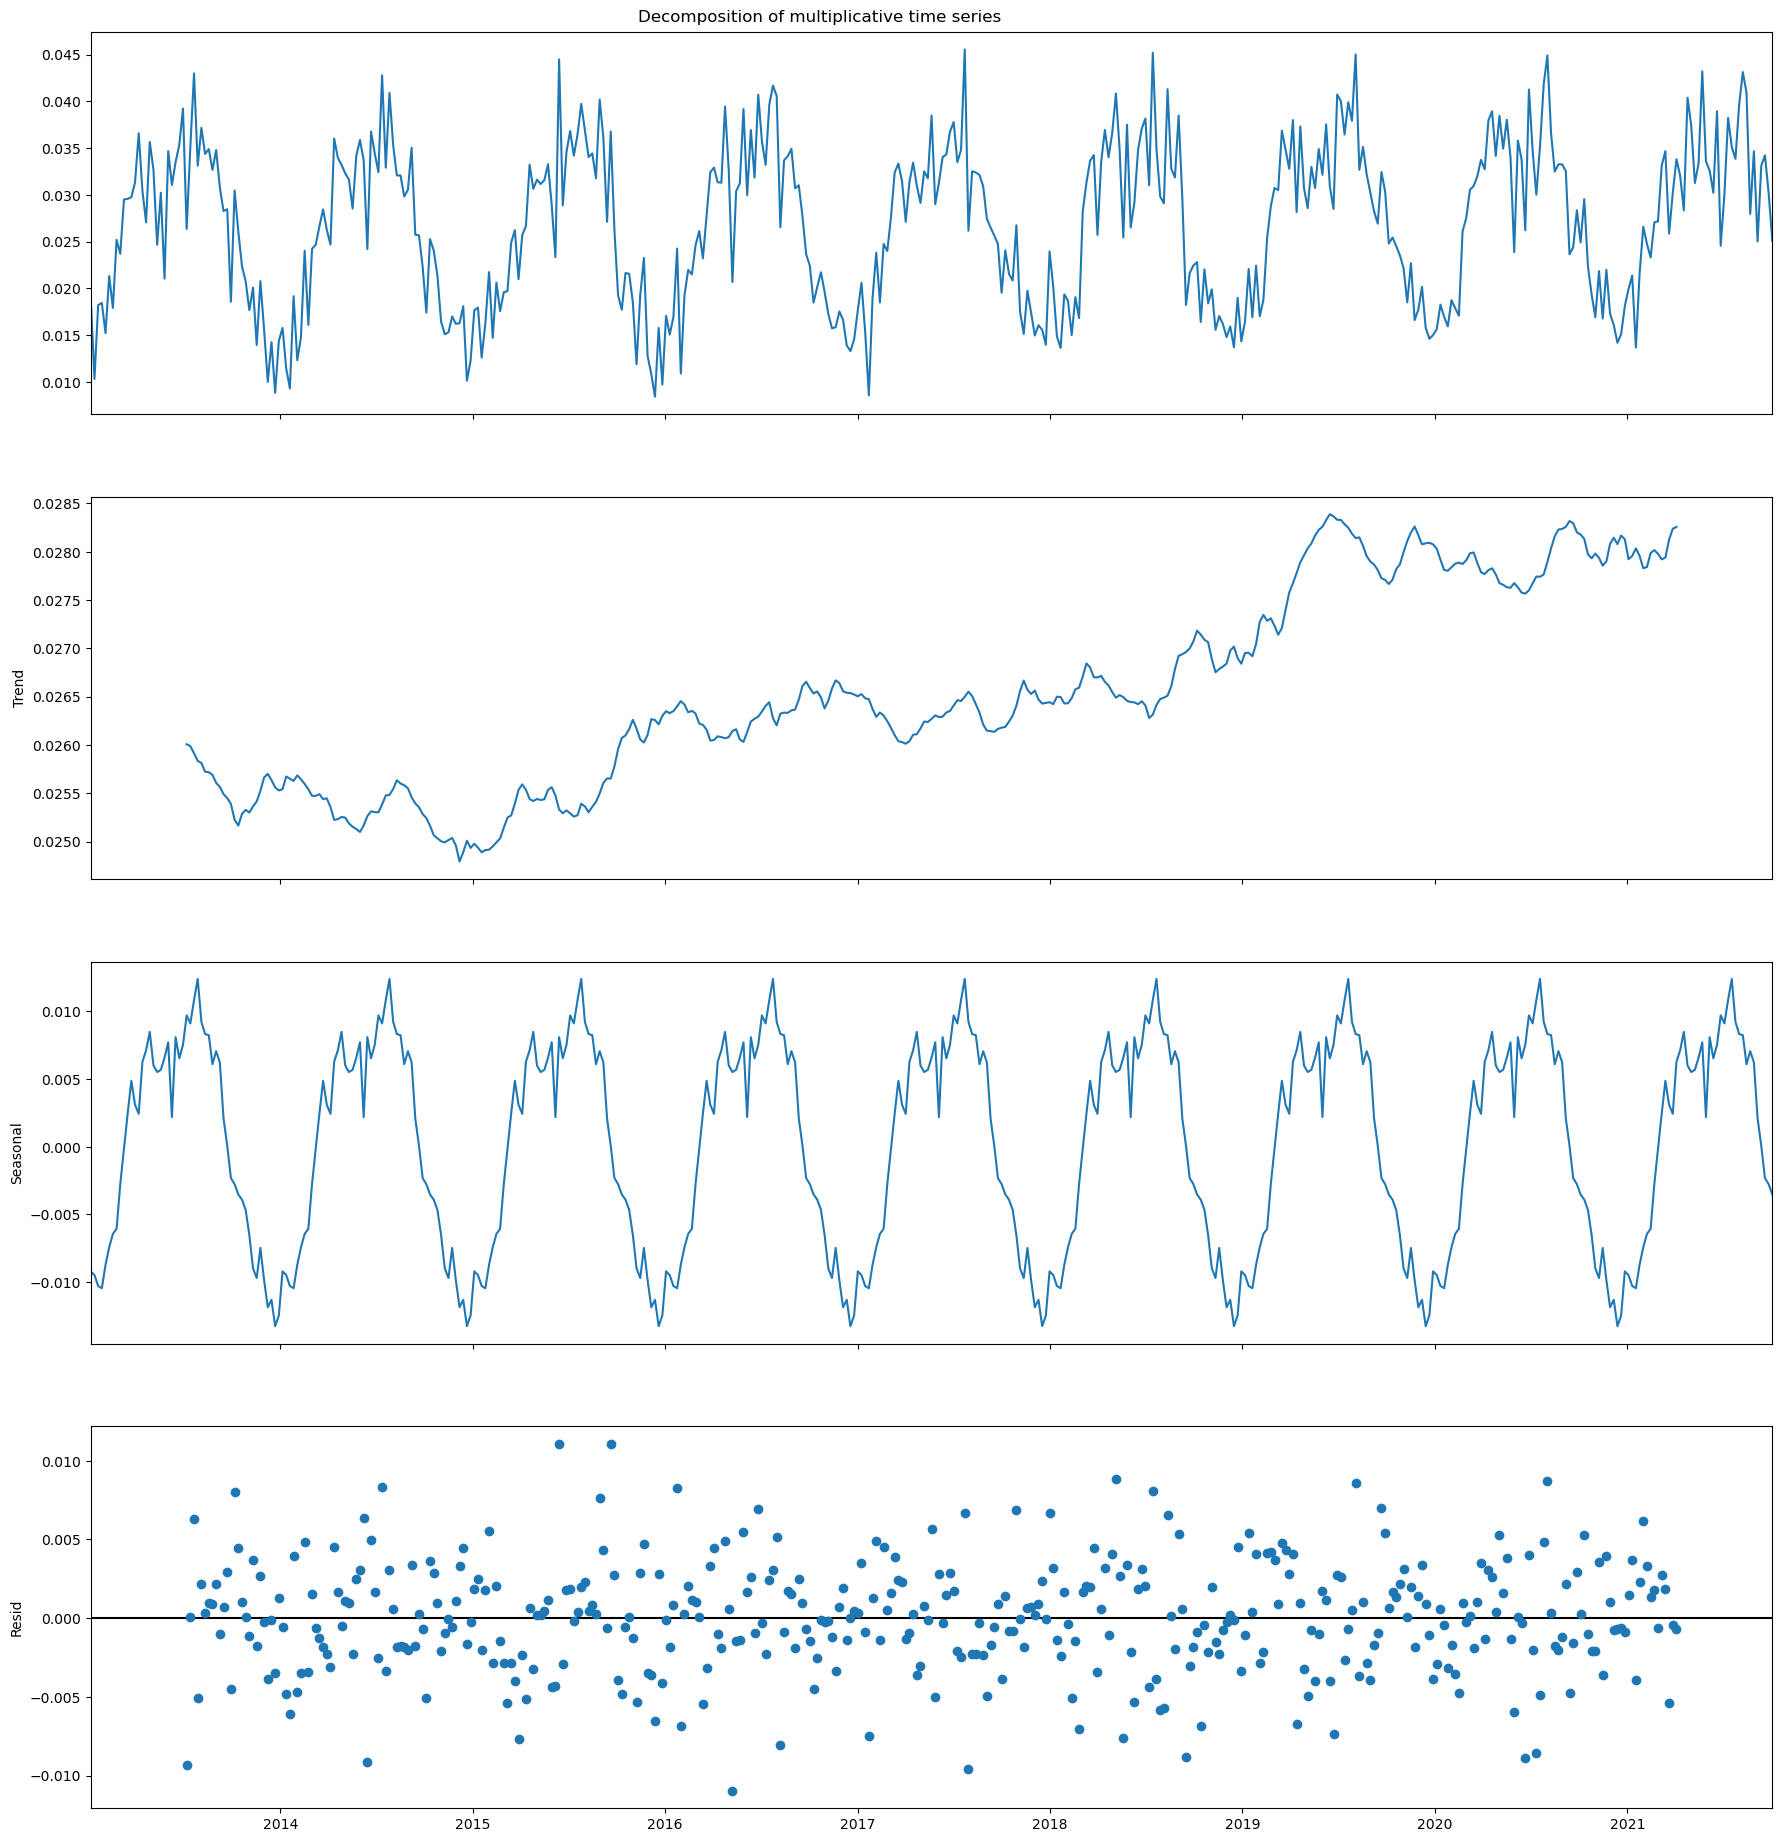

In [9]:
# fill-in missing dates
filled = W.asfreq('W')
filled = filled.ffill()

# decompose time-series
decomposition = seasonal_decompose(filled, model='additive')

# plot decomposed time-series data
fig = decomposition.plot()
fig.set_figwidth(20)
fig.set_figheight(20)
plt.suptitle('Decomposition of multiplicative time series')

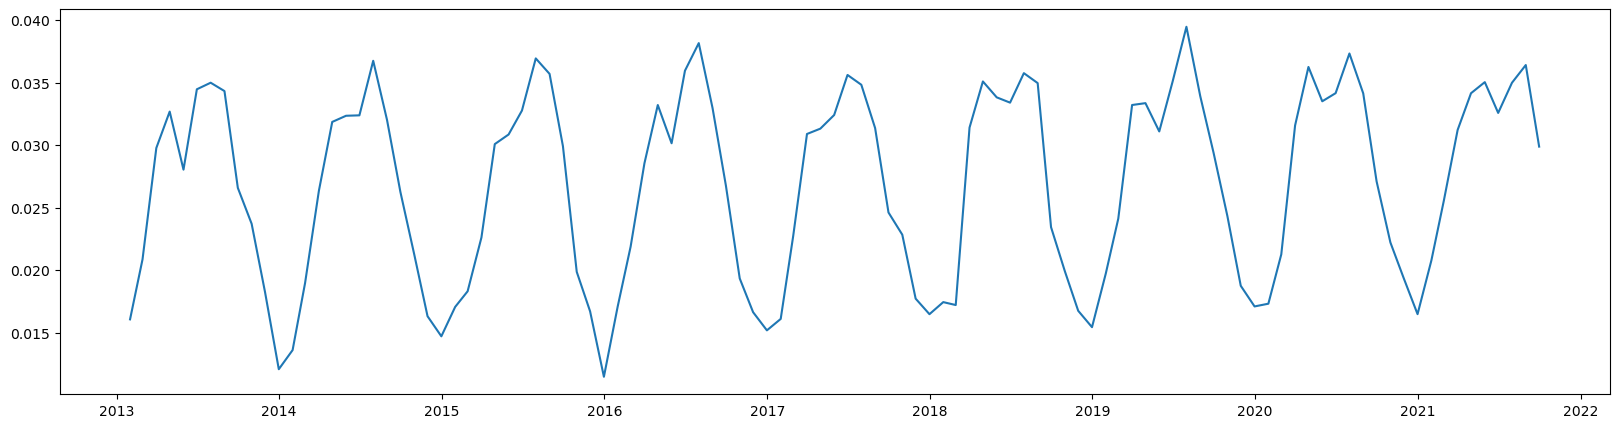

In [48]:
M = df_O3.resample('M').mean() #df_O3.rolling(window=30).mean().dropna()
plt.figure(figsize=(20,5));
plt.plot(M)

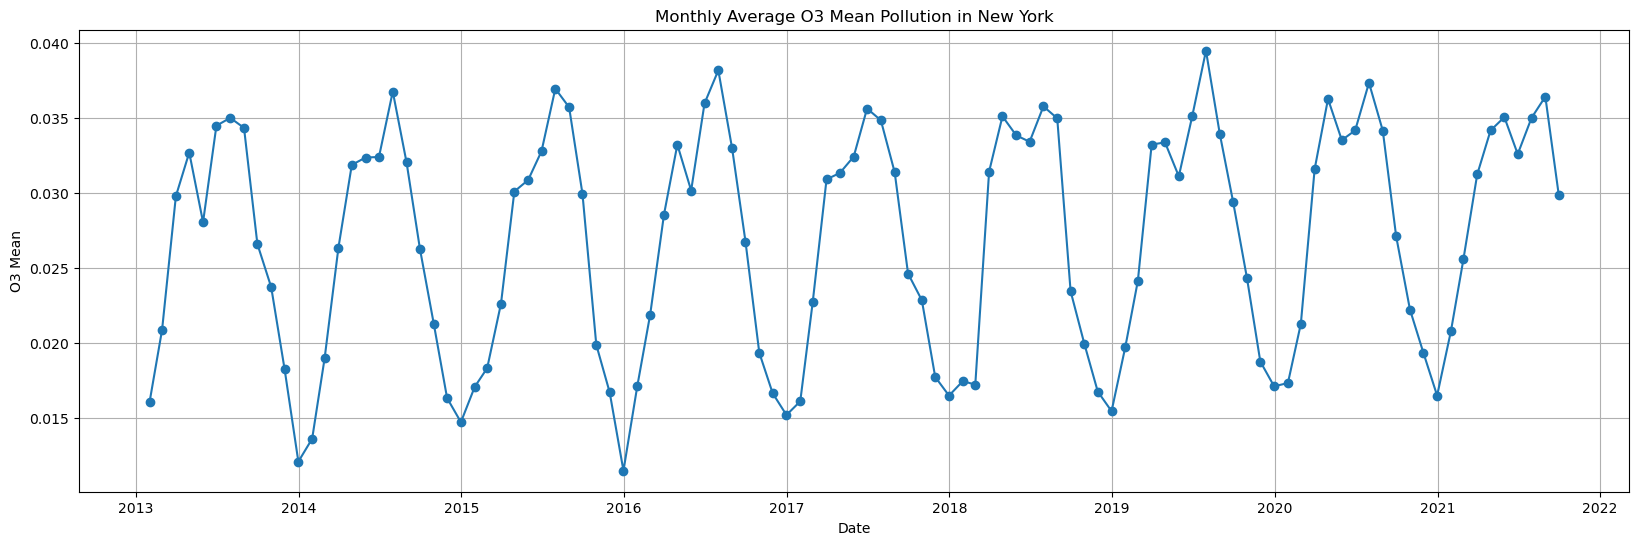

In [39]:
plt.figure(figsize=(20, 6))
plt.plot(M.index, M['O3 Mean'], marker='o', linestyle='-')
plt.title('Monthly Average O3 Mean Pollution in New York')
plt.xlabel('Date')
plt.ylabel('O3 Mean')
plt.grid(True)
plt.show()

Text(0.5, 0.98, 'Decomposition of multiplicative time series')

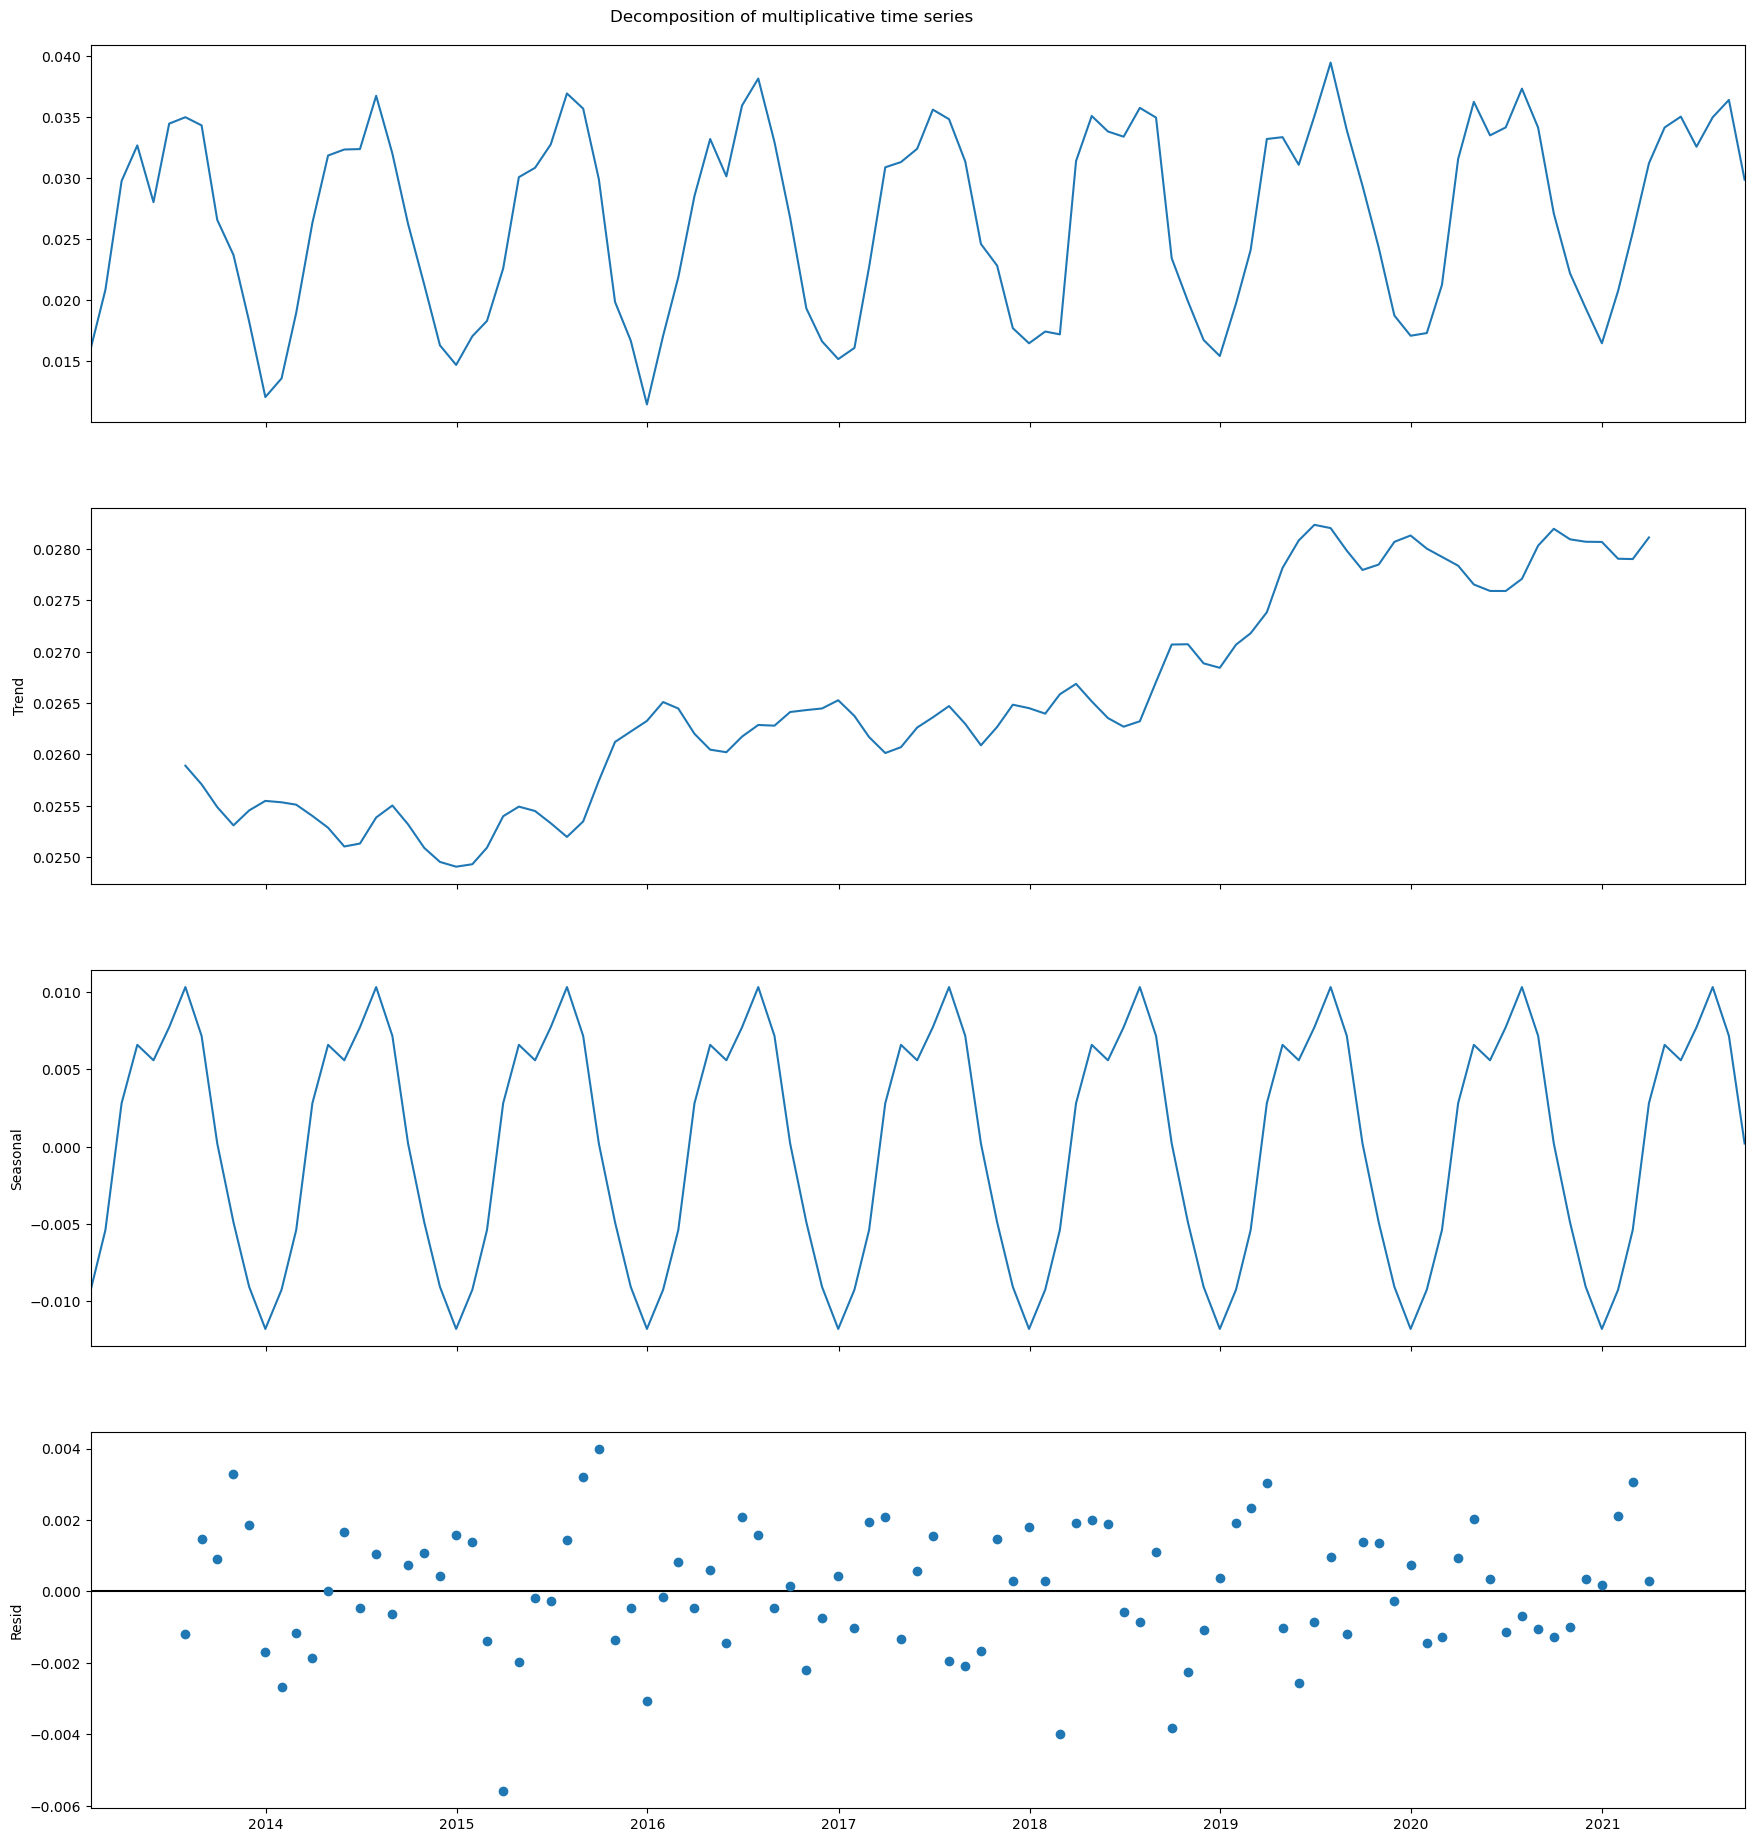

In [10]:
# fill-in missing dates
filled = M.asfreq('M')
filled = filled.ffill()

# decompose time-series
decomposition = seasonal_decompose(filled, model='additive')

# plot decomposed time-series data
fig = decomposition.plot()
fig.set_figwidth(20)
fig.set_figheight(20)
plt.suptitle('Decomposition of multiplicative time series')

## Check for Stationarity

In [11]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

#### Original Time-Series

In [12]:
check_stationarity(df_O3)

ADF Statistic: -4.144474
p-value: 0.000817
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


#### Resampled Time-Series

In [13]:
check_stationarity(M)

ADF Statistic: -0.614461
p-value: 0.867681
Critical Values:
	1%: -3.503
	5%: -2.893
	10%: -2.584
Non-stationary


In [14]:
check_stationarity(M.diff().dropna())

ADF Statistic: -6.449950
p-value: 0.000000
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584
Stationary


In [15]:
check_stationarity(W)

ADF Statistic: -7.529053
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Stationary


In [16]:
check_stationarity(W.diff().dropna())

ADF Statistic: -6.870370
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
Stationary


## ACF and PACF

#### Original Time-Series

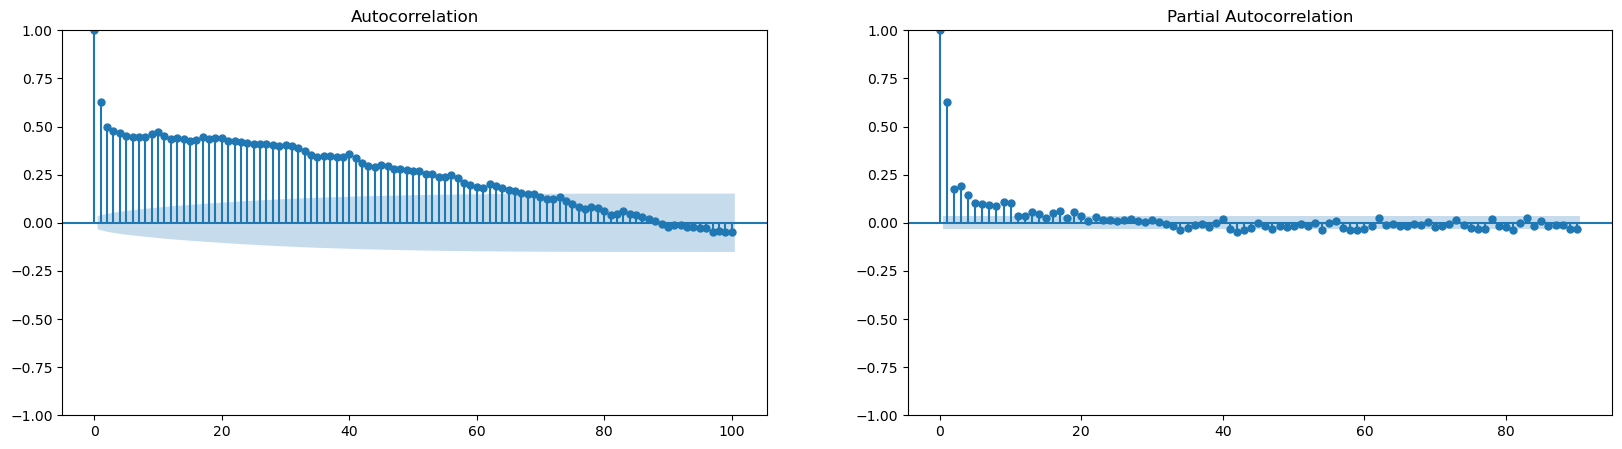

In [17]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plot_acf(df_O3, ax=ax[0], lags=100);
plot_pacf(df_O3, ax=ax[1],lags=90);

#### Resampled Time-Series

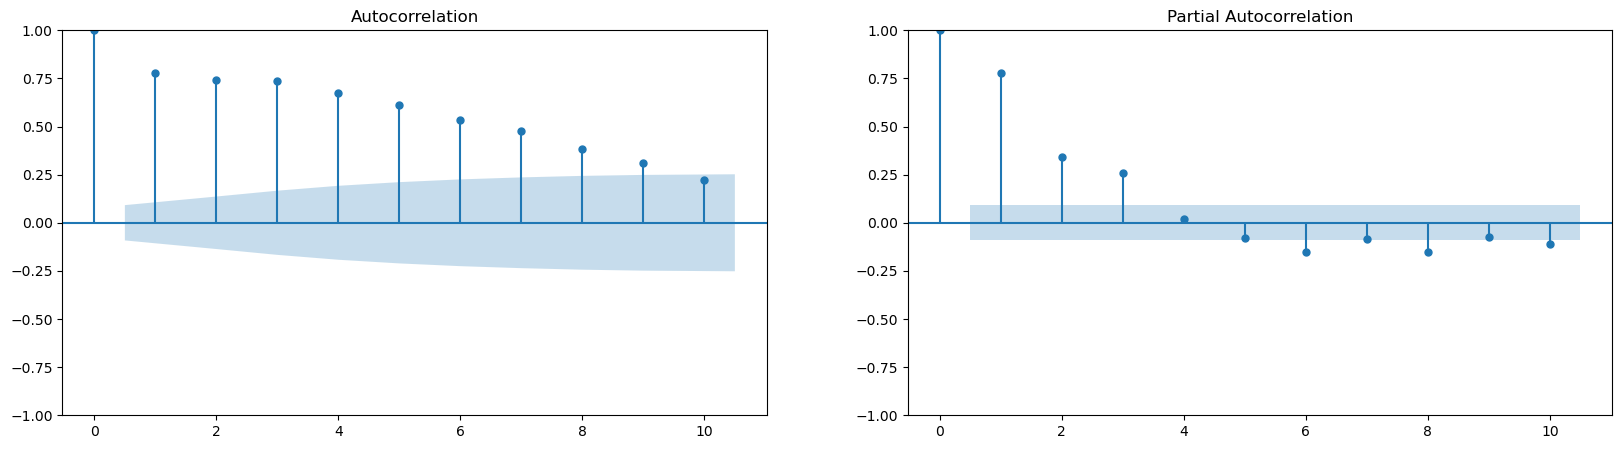

In [18]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plot_acf(W, ax=ax[0], lags = 10);
plot_pacf(W, ax=ax[1], lags = 10);

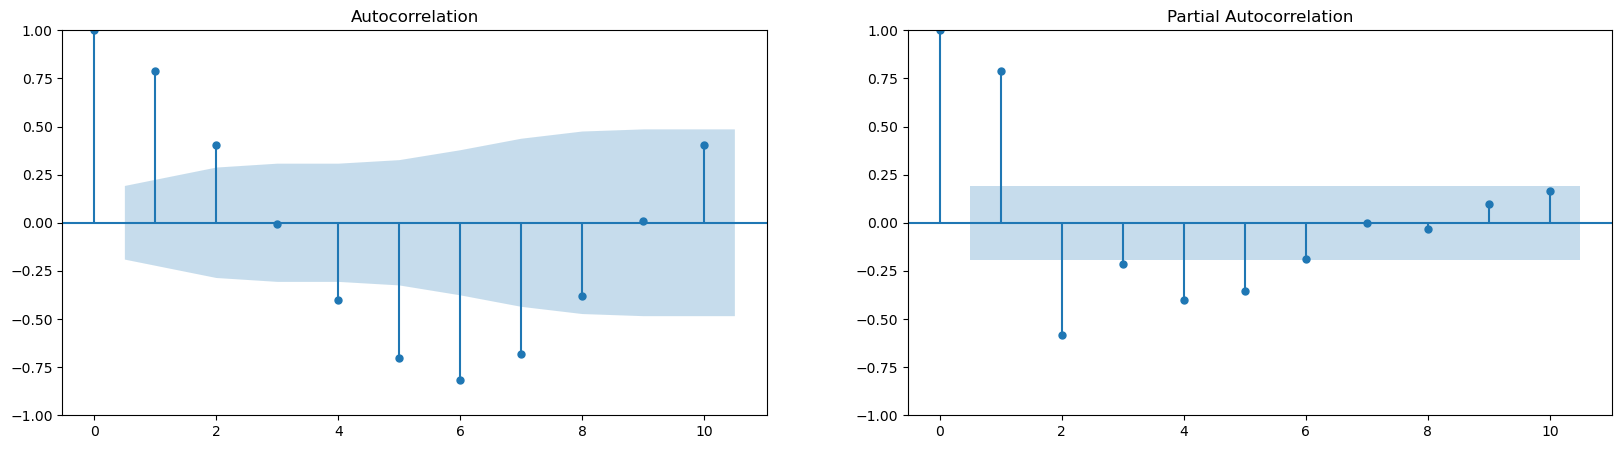

In [19]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
plot_acf(M, ax=ax[0], lags = 10);
plot_pacf(M, ax=ax[1], lags = 10);

## Train/Test Split

In [11]:
Wtrain = W.iloc[:-30]
Wtest = W[-30:]

print(f"Train df shape: {Wtrain.shape}")
print(f"Test df shape: {Wtest.shape}")

Train df shape: (427, 1)
Test df shape: (30, 1)


In [50]:
Mtrain = M.iloc[:-6]
Mtest = M[-12:]

print(f"Train df shape: {Mtrain.shape}")
print(f"Test df shape: {Mtest.shape}")

Train df shape: (99, 1)
Test df shape: (12, 1)


## Model Development: Arima

#### Optimal Parameter Search/Selection for the ARIMA Time Series Model

In [132]:
#W (4,0,8)
start_p =  1
max_p = 4
start_q =  8
max_q = 10
start_d = 0
max_d = 1

# Define the p, d and q parameters to take any values
p = range(start_p, max_p+1)
q = range(start_q, max_q+1)
d = range(start_d,max_d+1)

# Generate all different combinations of p, d and q triplets
pdq_params = list(itertools.product(p, d, q))

# fit different ARIMA models with different combinations of p,q,d
for param in pdq_params:
        # initialize model
        arima_model = ARIMA(
            Wtrain,
            order=param,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        # fit model
        out_arima = arima_model.fit()
        print('ARIMA {} - AIC:{}'.format(param, out_arima.aic))


ARIMA (1, 0, 8) - AIC:-3302.5188188713737
ARIMA (1, 0, 9) - AIC:-3245.6395029508685
ARIMA (1, 0, 10) - AIC:-3273.3723899039187
ARIMA (1, 1, 8) - AIC:-3277.102615513897
ARIMA (1, 1, 9) - AIC:-3268.5853955130515
ARIMA (1, 1, 10) - AIC:-3257.771185368157
ARIMA (2, 0, 8) - AIC:-3263.385091516813
ARIMA (2, 0, 9) - AIC:-3241.9757513711183
ARIMA (2, 0, 10) - AIC:-3264.474491635701
ARIMA (2, 1, 8) - AIC:-3273.9118119170103
ARIMA (2, 1, 9) - AIC:-3264.866505529325
ARIMA (2, 1, 10) - AIC:-3255.580511477313
ARIMA (3, 0, 8) - AIC:-3285.0129284203913
ARIMA (3, 0, 9) - AIC:-3289.494700359562
ARIMA (3, 0, 10) - AIC:-3273.0741822627488
ARIMA (3, 1, 8) - AIC:-3271.928786236135
ARIMA (3, 1, 9) - AIC:-3262.0977436417734
ARIMA (3, 1, 10) - AIC:-3255.5587388152926
ARIMA (4, 0, 8) - AIC:-3333.7497242014783
ARIMA (4, 0, 9) - AIC:-3309.943014971661
ARIMA (4, 0, 10) - AIC:-3303.9484320478045
ARIMA (4, 1, 8) - AIC:-3275.767193412121
ARIMA (4, 1, 9) - AIC:-3259.462307539565
ARIMA (4, 1, 10) - AIC:-3271.212107686

In [133]:
#M 
start_p =  6
max_p = 9
start_q =  1
max_q = 3
start_d = 0
max_d = 1

# Define the p, d and q parameters to take any values
p = range(start_p, max_p+1)
q = range(start_q, max_q+1)
d = range(start_d,max_d+1)

# Generate all different combinations of p, d and q triplets
pdq_params = list(itertools.product(p, d, q))

# fit different ARIMA models with different combinations of p,q,d
for param in pdq_params:
        # initialize model
        arima_model = ARIMA(
            Mtrain,
            order=param,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        # fit model
        out_arima = arima_model.fit()
        print('ARIMA {} - AIC:{}'.format(param, out_arima.aic))

ARIMA (6, 0, 1) - AIC:-818.5737722307352
ARIMA (6, 0, 2) - AIC:-814.4202697628666
ARIMA (6, 0, 3) - AIC:-754.7281278886293
ARIMA (6, 1, 1) - AIC:-770.1455920555068
ARIMA (6, 1, 2) - AIC:-809.6966306711175
ARIMA (6, 1, 3) - AIC:-796.5087168362707
ARIMA (7, 0, 1) - AIC:-806.9838161279965
ARIMA (7, 0, 2) - AIC:-806.9606050082841
ARIMA (7, 0, 3) - AIC:-797.5687403261751
ARIMA (7, 1, 1) - AIC:-765.4651956363962
ARIMA (7, 1, 2) - AIC:-768.3133751845721
ARIMA (7, 1, 3) - AIC:-764.2220416738727
ARIMA (8, 0, 1) - AIC:-801.0491925477197
ARIMA (8, 0, 2) - AIC:-796.0458355498466
ARIMA (8, 0, 3) - AIC:-798.0295271956822
ARIMA (8, 1, 1) - AIC:-768.4293509733485
ARIMA (8, 1, 2) - AIC:-774.8015589771998
ARIMA (8, 1, 3) - AIC:-793.0124588385659
ARIMA (9, 0, 1) - AIC:-789.9006643498991
ARIMA (9, 0, 2) - AIC:-788.0846795943698
ARIMA (9, 0, 3) - AIC:-786.0025496358458
ARIMA (9, 1, 1) - AIC:-768.1980402001996
ARIMA (9, 1, 2) - AIC:-774.6956860269888
ARIMA (9, 1, 3) - AIC:-775.3656544442443


####  Fitting an ARIMA Time Series Model with Optimal Parameters

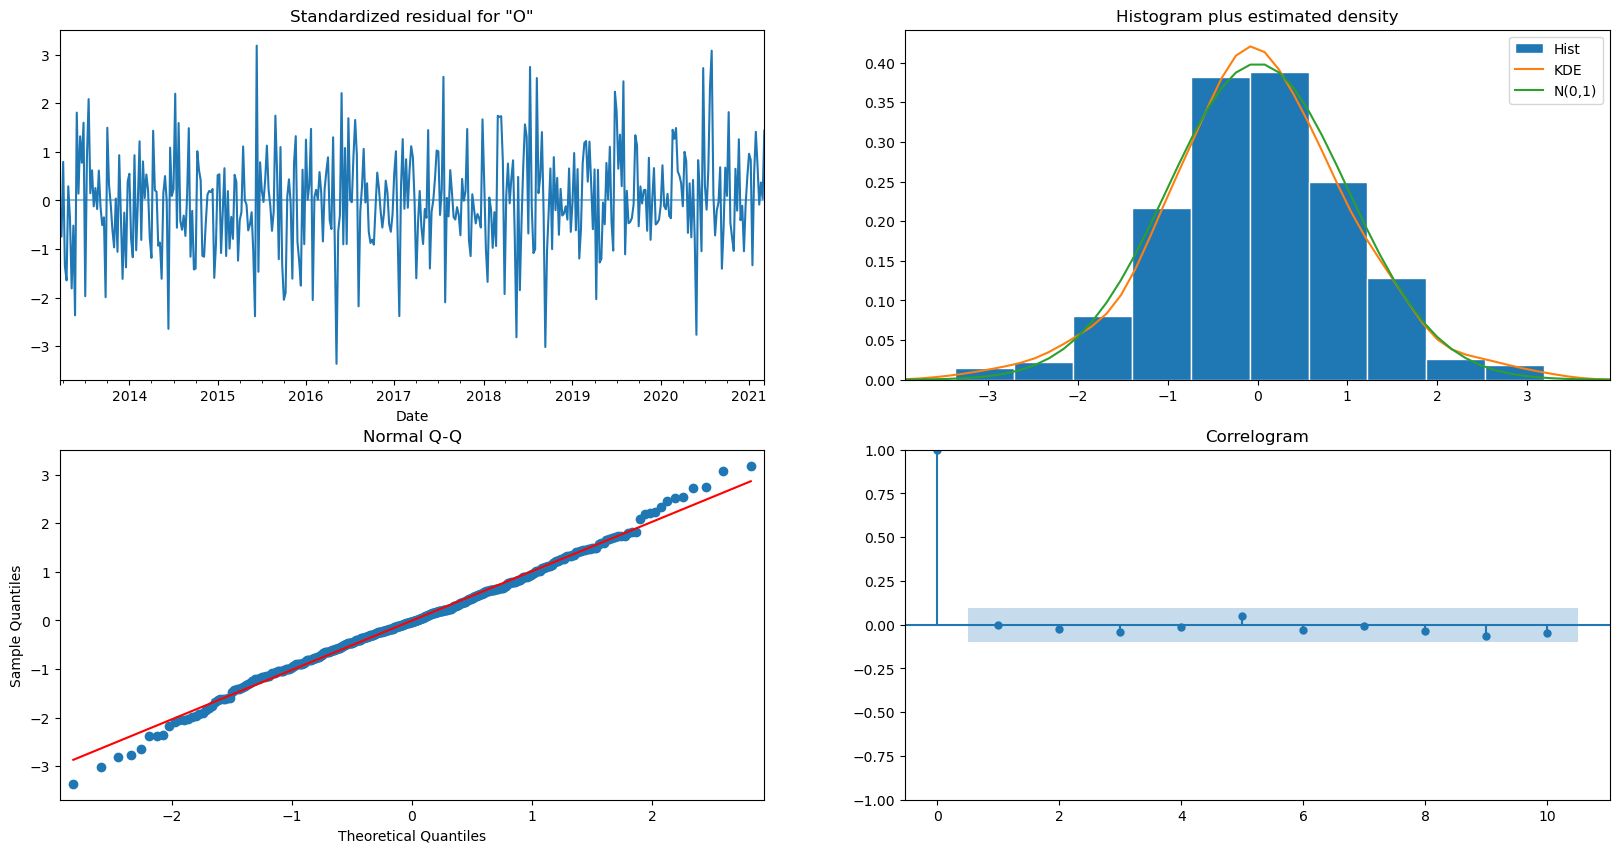

In [22]:
# W
W_arima_model = ARIMA(
    Wtrain,
    order=(6, 0, 10),   # specify optimal parameters from parameters search above
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit model
W_out_arima = W_arima_model.fit()

# QC model
W_out_arima.plot_diagnostics(figsize=(20, 10))
plt.show()

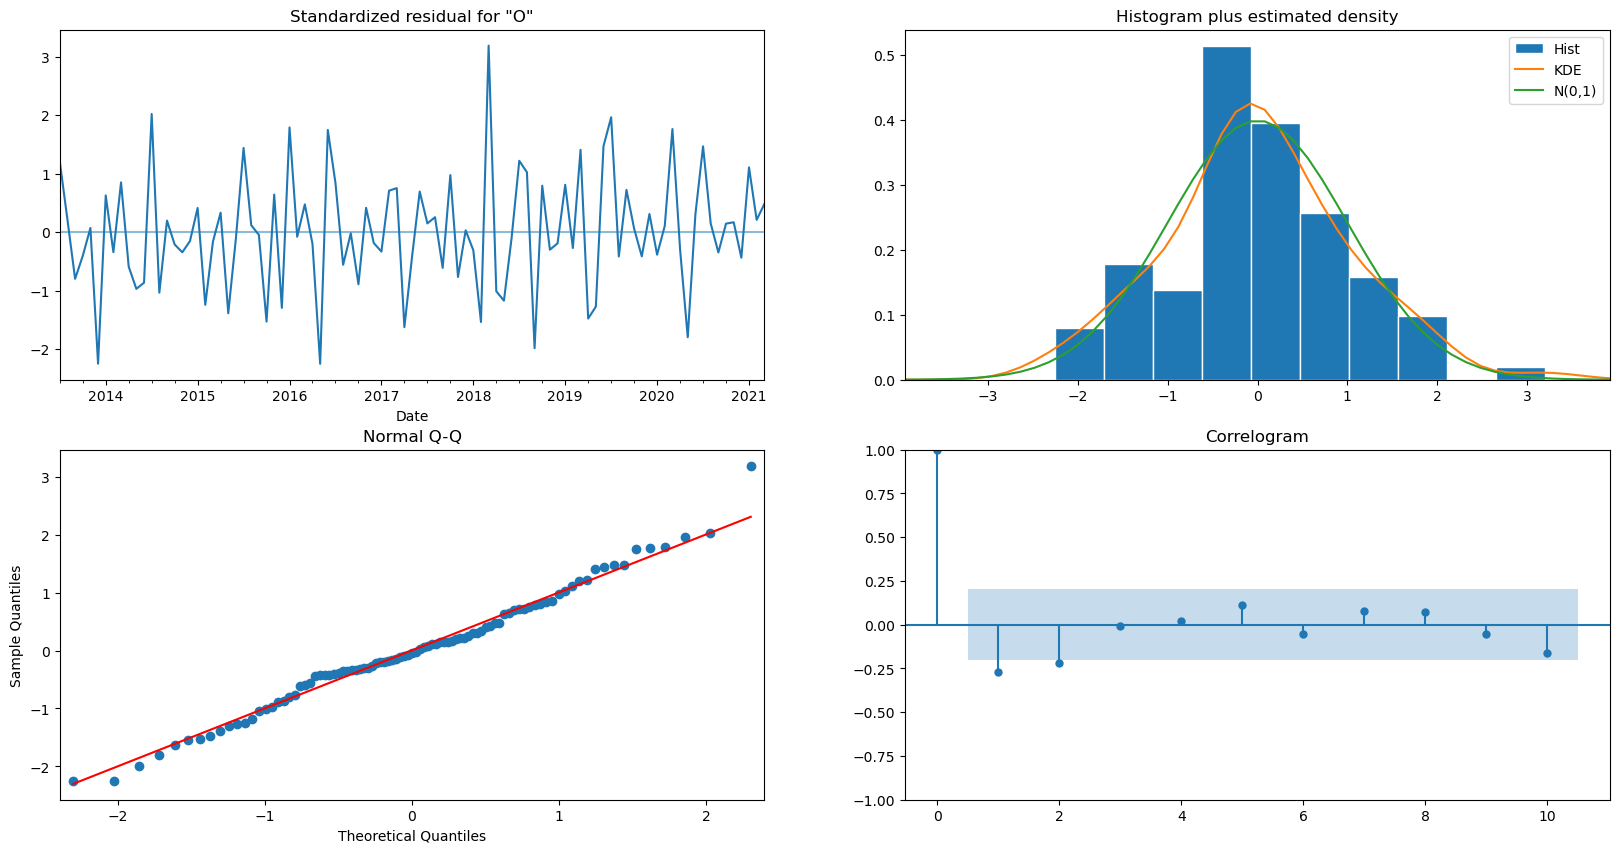

In [23]:
# M 4,0,8
M_Arima = ARIMA(
    Mtrain,
    order=(6, 0, 5),   # specify optimal parameters from parameters search above
    enforce_stationarity=False,
    enforce_invertibility=False
)

# fit model
M_out_arima = M_Arima.fit()

# QC model
M_out_arima.plot_diagnostics(figsize=(20, 10))
plt.show()

#### Arima Model Prediction

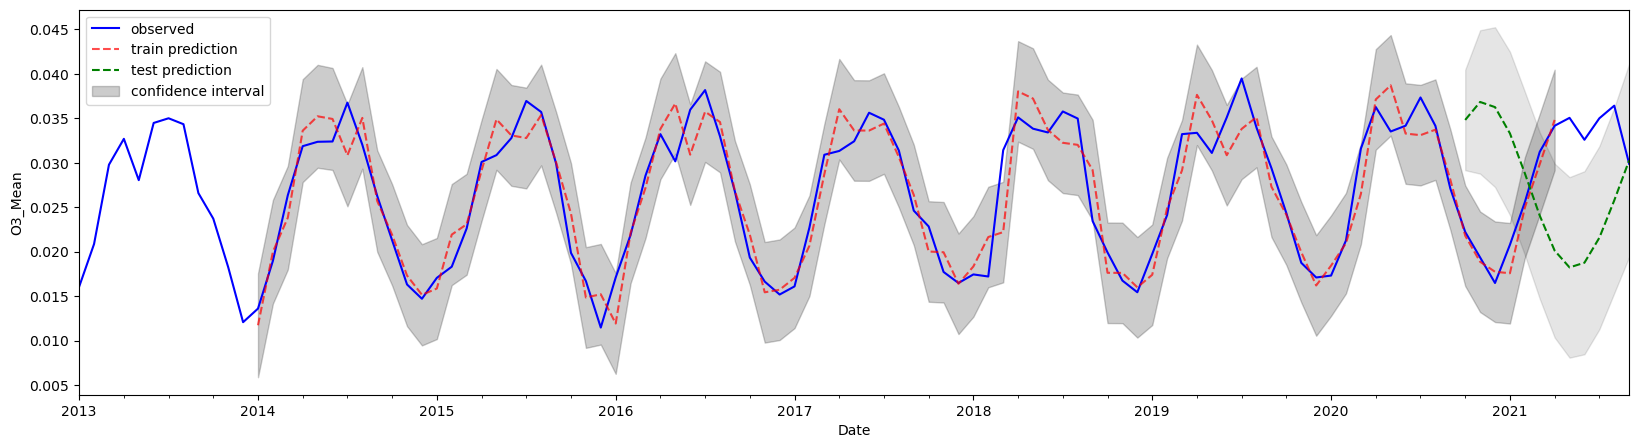

In [24]:
# M
pred_train = M_out_arima.get_prediction(
    start=pd.to_datetime('2014-01-31'),
    end =pd.to_datetime('2021-04-30'),
    dynamic=False,
    full_results=True
)
pred_ci_train = pred_train.conf_int()


# predict test data and confidence inetrval
pred_test = M_out_arima.get_forecast(
    steps=len(Mtest),
    dynamic = False,
    full_results=True
)
y_pred  =  pred_test.predicted_mean
y_pred.index = Mtest.index
pred_ci_test = pred_test.conf_int()
pred_ci_test.index = Mtest.index

# plot observed (actual) data
ax = M.plot(
    label='observed',
    color = "b",
    figsize=(20, 5),
)

# plot predicted train data
pred_train.predicted_mean.plot(ax=ax, label='train prediction', color='r', style = "--", alpha=0.7)

# plot predicted test data
y_pred.plot(ax=ax, label='test prediction', color='g', style = "--", alpha=1)

# plot confidence interval for predicted train data
ax.fill_between(pred_ci_train.index,
                pred_ci_train.iloc[:, 0],
                pred_ci_train.iloc[:, 1], color='k', alpha=.2)


# plot confidence interval for predicted test data
ax.fill_between(pred_ci_test.index,
               pred_ci_test.iloc[:, 0],
               pred_ci_test.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('O3_Mean')
plt.legend(["observed", "train prediction", "test prediction", "confidence interval"])
plt.show()

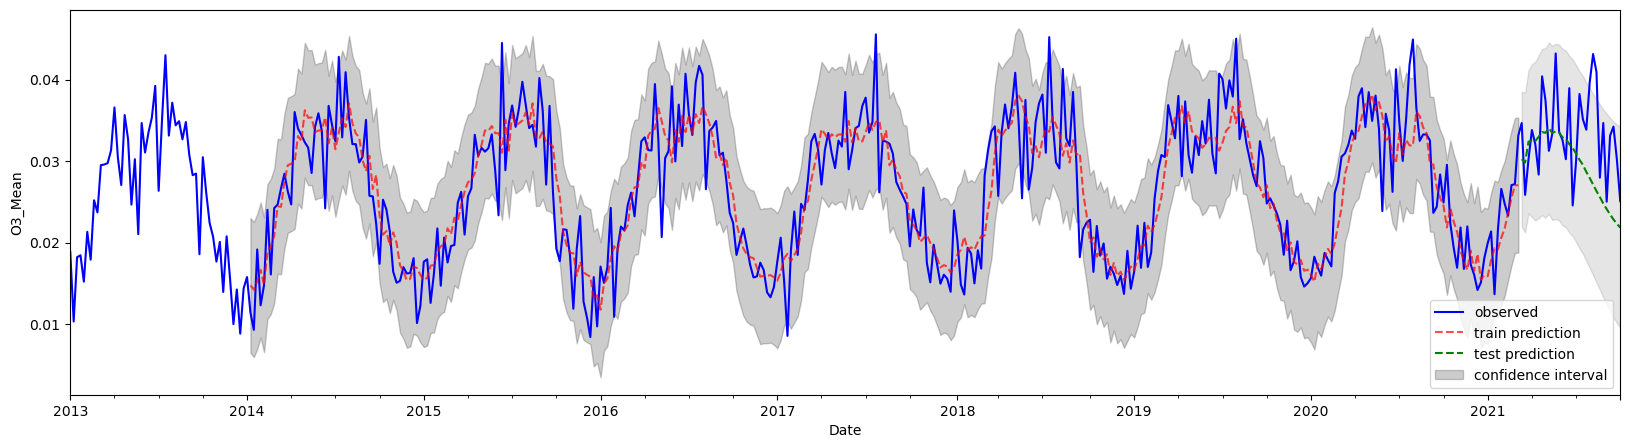

In [25]:
# predict train data and confidence interval
pred_train = W_out_arima.get_prediction(
    start=pd.to_datetime('2014-01-12'),
    end =pd.to_datetime('2021-03-07'),
    dynamic=False,
    full_results=True
)
pred_ci_train = pred_train.conf_int()


# predict test data and confidence inetrval
pred_test = W_out_arima.get_forecast(
    steps=len(Wtest),
    dynamic = False,
    full_results=True
)
y_pred  =  pred_test.predicted_mean
y_pred.index = Wtest.index
pred_ci_test = pred_test.conf_int()
pred_ci_test.index = Wtest.index

# plot observed (actual) data
ax = W.plot(
    label='observed',
    color = "b",
    figsize=(20, 5),
)

# plot predicted train data
pred_train.predicted_mean.plot(ax=ax, label='train prediction', color='r', style = "--", alpha=0.7)

# plot predicted test data
y_pred.plot(ax=ax, label='test prediction', color='g', style = "--", alpha=1)

# plot confidence interval for predicted train data
ax.fill_between(pred_ci_train.index,
                pred_ci_train.iloc[:, 0],
                pred_ci_train.iloc[:, 1], color='k', alpha=.2)


# plot confidence interval for predicted test data
ax.fill_between(pred_ci_test.index,
               pred_ci_test.iloc[:, 0],
               pred_ci_test.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('O3_Mean')
plt.legend(["observed", "train prediction", "test prediction", "confidence interval"])
plt.show()

In [138]:
#Sarima

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import seaborn as sns

<Axes: xlabel='Date', ylabel='O3 Mean'>

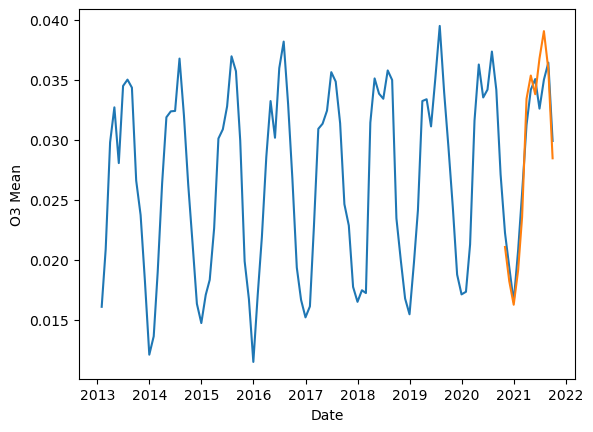

In [51]:
model = SARIMAX(Mtrain['O3 Mean'],order=(6,0,1),seasonal_order=(6,0,1,12))
model_fit=model.fit()
prediction = model_fit.predict(start=Mtest.index[0],end=Mtest.index[-1])
M['Sarima'] = prediction
sns.lineplot(data=M,x=M.index,y='O3 Mean')
sns.lineplot(data=M,x=M.index,y='Sarima')

<Axes: xlabel='Date', ylabel='O3 Mean'>

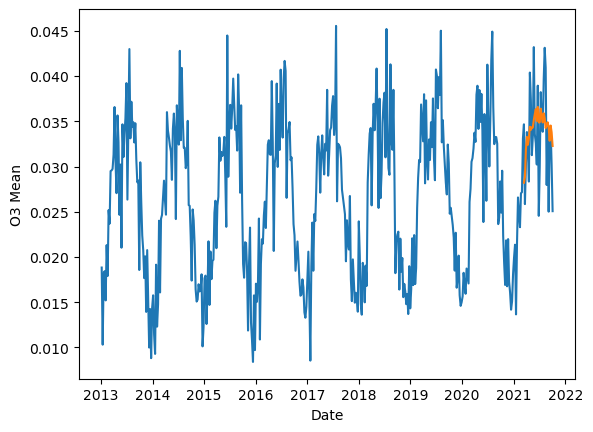

In [19]:
Wmodel = SARIMAX(Wtrain['O3 Mean'],order=(2,0,10),seasonal_order=(2,0,10,12))
Wmodel_fit= Wmodel.fit()
predictions = Wmodel_fit.predict(start=Wtest.index[0],end=Wtest.index[-1])
W['Sarima'] = predictions
sns.lineplot(data=W,x=W.index,y='O3 Mean')
sns.lineplot(data=W,x=W.index,y='Sarima')

#### Evaluate Fitted Arima Model

In [63]:
# Test error MSE
y_pred_test  =  M_out_arima.get_forecast(
    steps=len(Mtest),
    dynamic=False
).predicted_mean
y_pred_test.index = Mtest.index
y_truth_test = Mtest['O3 Mean']

# rmse
mse_test = (((y_pred_test - y_truth_test) ** 2).mean())
print('Test Mean Squared Error is {}'.format(mse_test))

Test Mean Squared Error is 2.0242619477715324e-05


In [64]:
# Test error MSE
y_pred_test  =  W_out_arima.get_forecast(
    steps=len(Wtest),
    dynamic=False
).predicted_mean
y_pred_test.index = Wtest.index
y_truth_test = Wtest['O3 Mean']

# rmse
mse_test = (((y_pred_test - y_truth_test) ** 2).mean())
print('Test Mean Squared Error is {}'.format(mse_test))

Test Mean Squared Error is 5.369490840783091e-05


In [27]:
y_pred_test = model_fit.get_forecast(steps=len(Mtest))

# Get predicted values
y_pred_values = y_pred_test.predicted_mean

# Set index for predicted values
y_pred_values.index = Mtest.index

# Extract true values from the test set
y_truth_test = Mtest['O3 Mean']

# Calculate Mean Squared Error (MSE)
mse_test = (((y_pred_values - y_truth_test) ** 2).mean())

# Print MSE
print('Test Mean Squared Error for SARIMA is {}'.format(mse_test))

Test Mean Squared Error for SARIMA is 0.00018215484519486726


In [29]:
mae_test = (abs(y_pred_values - y_truth_test)).mean()

# Print MAE
print('Test Mean Absolute Error (MAE) for SARIMA is {}'.format(mae_test))

Test Mean Absolute Error (MAE) for SARIMA is 0.012546187198209338


In [25]:
num_steps = 36

# Forecast future values
forecast = model_fit.forecast(steps=num_steps)

# Print the forecasted values
print("Forecasted values for the next year:")
print(forecast)

Forecasted values for the next year:
2021-04-30    0.035345
2021-05-31    0.033784
2021-06-30    0.036773
2021-07-31    0.039044
2021-08-31    0.035852
2021-09-30    0.028444
2021-10-31    0.022930
2021-11-30    0.019765
2021-12-31    0.017665
2022-01-31    0.020218
2022-02-28    0.024921
2022-03-31    0.033548
2022-04-30    0.035225
2022-05-31    0.034364
2022-06-30    0.037271
2022-07-31    0.038734
2022-08-31    0.034990
2022-09-30    0.028092
2022-10-31    0.024507
2022-11-30    0.020220
2022-12-31    0.018956
2023-01-31    0.020303
2023-02-28    0.022934
2023-03-31    0.033734
2023-04-30    0.036343
2023-05-31    0.035070
2023-06-30    0.036242
2023-07-31    0.038509
2023-08-31    0.036005
2023-09-30    0.027829
2023-10-31    0.024099
2023-11-30    0.020305
2023-12-31    0.018544
2024-01-31    0.021474
2024-02-29    0.024893
2024-03-31    0.034072
Freq: M, Name: predicted_mean, dtype: float64


In [15]:
import matplotlib.pyplot as plt


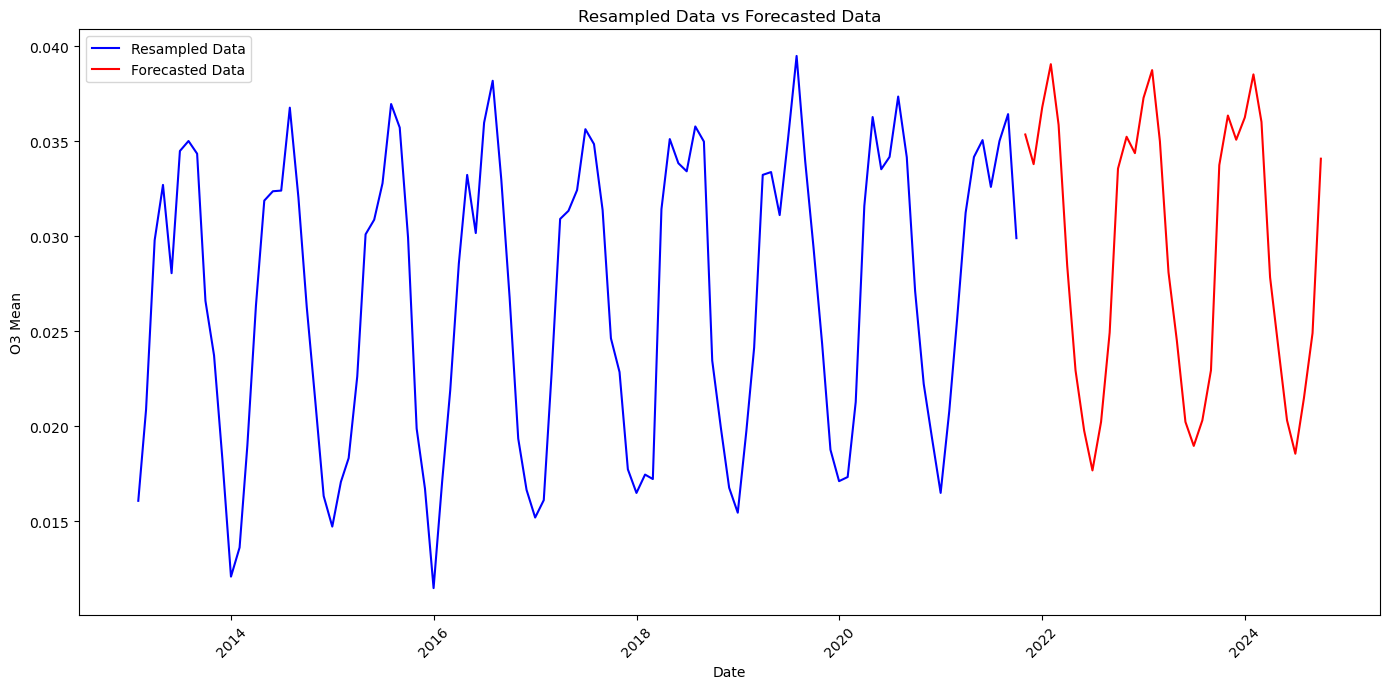

In [26]:
plt.figure(figsize=(14, 7))

# Plot resampled data
plt.plot(M.index, M['O3 Mean'], label='Resampled Data', color='blue')

# Plot forecasted data
forecast_index = pd.date_range(start=M.index[-1], periods=num_steps+1, freq='MS')[1:]
plt.plot(forecast_index, forecast, label='Forecasted Data', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('O3 Mean')
plt.title('Resampled Data vs Forecasted Data')
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

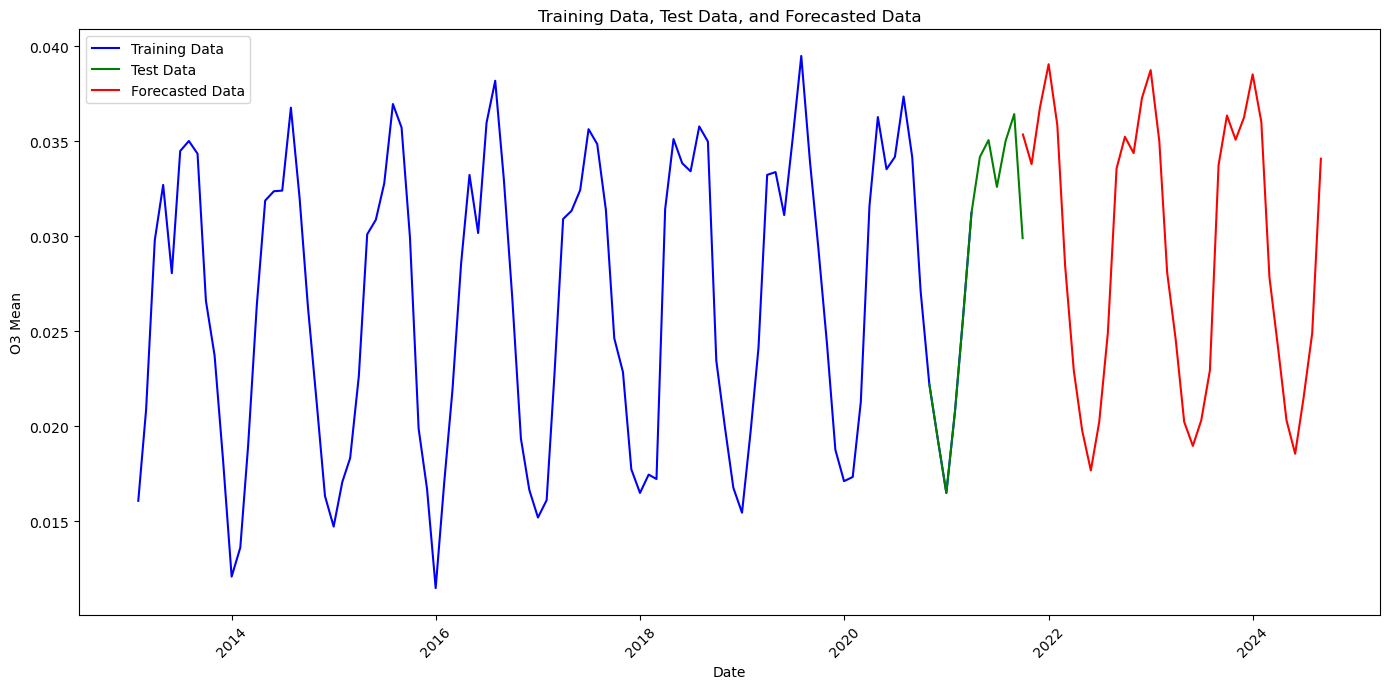

In [55]:
import matplotlib.pyplot as plt

# Assuming 'M' is your training data, 'test_data' is your test data, and 'forecast' is your forecasted data

plt.figure(figsize=(14, 7))

# Plot training data
plt.plot(Mtrain.index, Mtrain['O3 Mean'], label='Training Data', color='blue')

# Plot test data
plt.plot(Mtest.index, Mtest['O3 Mean'], label='Test Data', color='green')

end_date = Mtest.index[-1]

# Create a date range starting from the day after the end date of the testing data
forecast_index = pd.date_range(start=end_date + pd.Timedelta(days=1), periods=len(forecast), freq='MS')
plt.plot(forecast_index, forecast, label='Forecasted Data', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('O3 Mean')
plt.title('Training Data, Test Data, and Forecasted Data')
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()